## Superfluid Dark Matter

In this notebook, we derive the density profile of a galaxy consisting of superfluid dark matter. We will use the theoretical results from this [Paper](https://arxiv.org/pdf/1809.08286.pdf) that I published during my PhD and much of the code relies on equations derived in this paper. 

We begin by fixing the mass of the particle, the interaction strength and the temperature of the dark matter halo. The particle mass and interaction strength is taken so as to reproduce realistic galaxy configurations in accordance with the calculations in section 6.1. The average temperature of the dark matter halo is fixed by its overall mass and size and towards the end, which we get from the theory of standard collapse, and use that temperature assuming our dark matter halo is isothermal. We'll test this assumption be verifying the numerically derived temperature with the theoretical temperature. 

In [2]:
import numpy as np
import mpmath
import math
import scipy.integrate as integrate
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

All values below are in natural units and expressed in electron Volts (eV). g is the interaction strength in eV<sup>-2 </sup>

In [3]:
m = 0.5
g=10.0**-1.0
t=10**(-6.0)

def a(g,m):
    return m*g/(4.0*math.pi)

def y(rho,g,m):
    return rho**(1.0/3.0)*a(g,m)

def s2(n1,sigma,rho,g,m):
    return 4.0*math.pi*a(g,m)*rho**(1.0/3.0)*(1.0-n1+sigma)

We initialize a bunch of lists that we shall be using in our analysis. The rho1list and pressure1list are used in the regime where there is no condensation. This is the case when the density is below a certain threshold called the criticalrho which we calculate below using the known theoretical results. We'll verify that in the case of weak interactions, the condensate vanishes at the same density as given by theory.

rho2alist and pressure2alist will be used when a fraction of the interacting particles form a Bose-Einstein Condensate (BEC). The equations to solve are completely different in the two regimes as we shall see.

In [4]:
rho1list =[];
rho2alist =[];
pressure1list = [];
pressure2alist =[];

#rho2blist = [];
#pressure2blist=[];

r = [];
r = np.zeros(2)

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

In [5]:
criticalrho = (m*t/3.35)**1.5
criticalrho

5.766174696166088e-11

We create two different arrays of density for the two regimes. rho1 corresponds to the case where there will be no condensate and rho2 corresponds to the presence of BEC. 

In [6]:
rho1 = np.logspace(-15.0,-10.23111220405124 , num=300)
rho2 = np.logspace(-10.2121220405124,-6.0 , num=300)

We now use the equation of state for an interacting Bose gas as given by equation (57) and (58) in the paper. We first solve for the chemical potential and back substitute it to derive the pressure of the gas. 

In [7]:
for i in my_range(0,299,1):
    rho =rho1[i]
    if m*t/(rho**(2.0/3.0)) > 3.35:
        def equations1(b):
            u = b
            f = rho -1.414*0.886*(m*t)**(1.5)/(2.0*math.pi**2.0)* mpmath.polylog(1.5,math.exp((u-2.0*rho*g)/t))
            return f
        
        b = fsolve(equations1,[-0.0000000001])
        #print (b)
        def pressure(b):
            return g*rho**2.0 + 1.414*t**(2.5)*m**(1.5)/(2*math.pi**2.0)*mpmath.polylog(2.5,math.exp((b-2.0*rho*g)/t))/(1.5)*1.3294
        

        #print (rho)
        #print (pressure(b))
        rho1list.append(rho)
        pressure1list.append(pressure(b))
        #print ("\n")


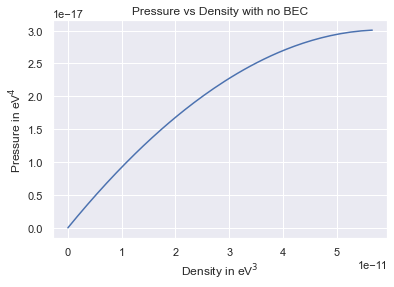

In [12]:
sns.set()
plt.plot(rho1list,pressure1list);
plt.title('Pressure vs Density with no BEC')
plt.xlabel('Density in eV$^3$')
plt.ylabel('Pressure in eV$^4$');

Now we compute the equation of state in the presence of Bose-Einstein Condensates. We irst solve the implicit equations (47) that give us the condensate fraction and the anomalous average at a particular T, V, N. Subsequently, we use equaiton (54) to compute the pressure. The integrals in the implicit equations diverge because of or treatment of interactions between the particles as arising from physical contact. They are suitabl regularized and the converge time near the critical temperature can be a bit high for strong interactions.

In [14]:
for i in my_range(0,299,1):

    rho =rho2[i]
    
    
    if m*t/(rho**(2.0/3.0)) < 3.31:
        def equations2(r):
            n1 = r[0]
            sigma = r[1]
            f = np.zeros(2)
            f[0] = n1 - (s2(n1,sigma,rho,g,m)**(3.0/2.0))/(3.0*math.pi*math.pi)*(1.0 + (3.0/(2.0*math.sqrt(2.0))) *integrate.quad(lambda x: math.sqrt(math.sqrt(1.0+x**2.0)-1.0)*((1.0/np.tanh(s2(n1,sigma,rho,g,m)*x*rho**(2.0/3.0)/(2.0*t*m)))-1.0),0.0, 100.0*(20.0*t*m/(s2(n1,sigma,rho,g,m) *rho**(2.0/3.0) )) )[0])

            f[1] = sigma - (2.0*s2(n1,sigma,rho,g,m)/(math.pi**(1.5)))*(math.sqrt(y(rho,g,m) - y(rho,g,m)*n1)) + ((s2(n1,sigma,rho,g,m)**(3.0/2.0))/(2.0*math.sqrt(2.0)*(math.pi**2.0)) )*integrate.quad(lambda x: (math.sqrt(math.sqrt(1.0+x**2.0)-1.0)/(math.sqrt(1.0+x**2.0)) )*((1.0/np.tanh(s2(n1,sigma,rho,g,m)*x*rho**(2.0/3.0)/(2.0*t*m)))-1.0),0.0, 10.0*(20.0*t*m/(s2(n1,sigma,rho,g,m) * rho**(2.0/3.0) )) )[0]

            #f2 = b - (4*(1+b-a)/math.sqrt(math.pi))*(math.sqrt(.5 - .5*a))- ((2*math.pi*(1+b-a))**(1.5))/(2*math.sqrt(2)*math.pi*math.pi)

            return f
        def pressure0(n1,sigma):
            return -(g*rho**2.0)*( ( (1.0-n1)/2.0 -1.0 -n1-sigma )*(1.0-n1)- n1**2.0 -(sigma**2.0)/2.0)
        def pressure1(n1,sigma):
            return -t*integrate.quad(lambda k: (k**2.0)*math.log(1.0- math.exp(-(math.sqrt((k**2.0)/(2.0*m) *((k**2.0)/(2.0*m) + 2.0*(rho)*(g)*(1.0-n1+sigma) ) ))/(t))),0.0, 30.0*m*math.sqrt(t) )[0]/(2.0*math.pi*math.pi)

        r = fsolve(equations2, [0.6,0.2])
        #print (r)
        #print (rho)
        #print (pressure0(r[0],r[1]))
        #print (pressure1(r[0],r[1]))
        #print ("\n")
        rho2alist.append(rho)
        pressure2alist.append(pressure0(r[0],r[1]) + pressure1(r[0],r[1]) )

C:\Users\anush\AppData\Local\Temp/ipykernel_9044/2369312236.py:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  f[1] = sigma - (2.0*s2(n1,sigma,rho,g,m)/(math.pi**(1.5)))*(math.sqrt(y(rho,g,m) - y(rho,g,m)*n1)) + ((s2(n1,sigma,rho,g,m)**(3.0/2.0))/(2.0*math.sqrt(2.0)*(math.pi**2.0)) )*integrate.quad(lambda x: (math.sqrt(math.sqrt(1.0+x**2.0)-1.0)/(math.sqrt(1.0+x**2.0)) )*((1.0/np.tanh(s2(n1,sigma,rho,g,m)*x*rho**(2.0/3.0)/(2.0*t*m)))-1.0),0.0, 10.0*(20.0*t*m/(s2(n1,sigma,rho,g,m) * rho**(2.0/3.0) )) )[0]
C:\Users\anush\AppData\Local\Temp/ipykernel_9044/2369312236.py:11: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  f[0] = n1 - (s2(n1,sigma,rho,g,m)**(3.0/2.0))/(3.0*math.pi*math.pi)*(1.0 + (3.0/(2.0*math.sqrt(2.0))) *integrate.quad(la

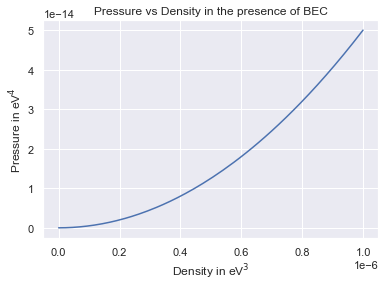

In [15]:
plt.plot(rho2alist,pressure2alist);
plt.title('Pressure vs Density in the presence of BEC')
plt.xlabel('Density in eV$^3$')
plt.ylabel('Pressure in eV$^4$');

We'll use the two different regimes to create pressure as functions of density. This will be needed for or next step which is to use the equation of state to compute the density profile of dark matter.

In [16]:
from scipy.interpolate import UnivariateSpline
interpolatedpressure1 = UnivariateSpline(rho1list, pressure1list, k=5, s=0)

In [17]:
#spl = interp1d(rho2alist, pressure2alist, kind='cubic')
#plt.plot(rho2alist[:2],'g^')

interpolatedpressure2 = UnivariateSpline(rho2alist, pressure2alist, k=5, s=0)

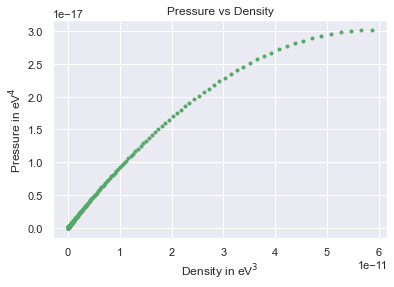

In [18]:
plt.plot(rho1[:],interpolatedpressure1(rho1[:]),'g.');
plt.title('Pressure vs Density')
plt.xlabel('Density in eV$^3$')
plt.ylabel('Pressure in eV$^4$');

Text(0, 0.5, 'Pressure in eV$^4$')

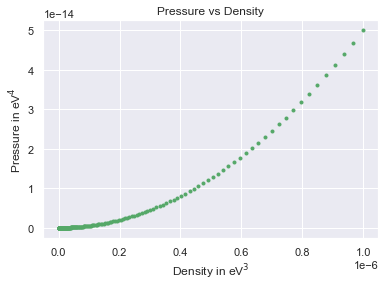

In [20]:
plt.plot(rho2,interpolatedpressure2(rho2),'g.');
plt.title('Pressure vs Density')
plt.xlabel('Density in eV$^3$')
plt.ylabel('Pressure in eV$^4$')

We assume that the inward pull of gravity on dark matter particles is cancelled by the pressure of the bose gas constituting dakr matter. Thus, we need to solve the equation for hydrostatic equilibrium. In order to do that we need to compute the first and second order derivatives of the equation of state.

In [21]:
interpolateddpdrho1 =interpolatedpressure1.derivative()
interpolateddpdrho2 =interpolatedpressure2.derivative()

We see that the first derivative is continuous. This tells us that our phase transition is not first-order.

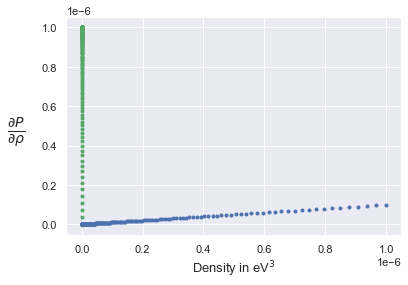

In [24]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots()

plt.plot(rho1,interpolateddpdrho1(rho1),'g.',rho2,interpolateddpdrho2(rho2),'b.');
plt.xlabel('Density in eV$^3$', fontsize = 13)
plt.ylabel(r'$\frac{\partial P}{\partial \rho}$', rotation = 0,fontsize = 20 )


ax.yaxis.set_label_coords(-.15, .4)

As a consistency check, we plot the first derivative of the equation of state in the presence of BEC. Since we are assuming two-point contact interactions, the pressure should scale as the sqaure of the density and the first derivative of density should be linear, which is what we observe below.

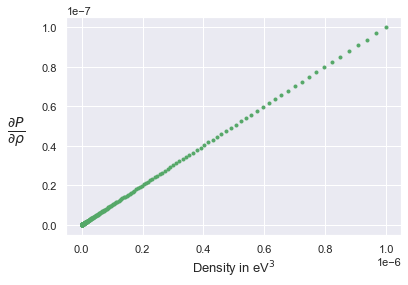

In [26]:
fig, ax = plt.subplots()
plt.plot(rho2,interpolateddpdrho2(rho2),'g.');
plt.xlabel('Density in eV$^3$', fontsize = 13)
plt.ylabel(r'$\frac{\partial P}{\partial \rho}$', rotation = 0,fontsize = 20 )


ax.yaxis.set_label_coords(-.15, .4)

Now we compute the second order derivatives.

In [27]:
interpolatedd2pdrho21 =interpolateddpdrho1.derivative()
interpolatedd2pdrho22 =interpolateddpdrho2.derivative()

The second order derivative is not continuous. This is expected because the phase transition of a BEC is of second-order.

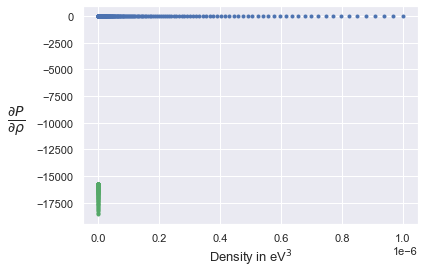

In [29]:
fig, ax = plt.subplots()
plt.plot(rho1,interpolatedd2pdrho21(rho1),'g.',rho2,interpolatedd2pdrho22(rho2),'b.');
plt.xlabel('Density in eV$^3$', fontsize = 13)
plt.ylabel(r'$\frac{\partial P}{\partial \rho}$', rotation = 0,fontsize = 20 )


ax.yaxis.set_label_coords(-.20, .4)

B is the conversion factor for one solar mass from kg to eV.

In [30]:
B=1.5*10**56.0
def f(rhor,drhor, r):
    #if rhor < 5.87337588753e-11:
    # derivs = -4.0*math.pi*rhor**2.0/(B*interpolateddpdrho1(rhor)) - 2.0*drhor/r - drhor**2.0*(interpolatedd2pdrho21(rhor)/interpolateddpdrho1(rhor)- 1.0/rhor)
    if rhor > 5.87337588753e-11:
        derivs = -4.0*math.pi*rhor**2.0/(B*interpolateddpdrho2(rhor)) - 2.0*drhor/r - drhor**2.0*(interpolatedd2pdrho22(rhor)/interpolateddpdrho2(rhor)- 1.0/rhor)
    else:
        derivs = 0
    return derivs

We now solve the hydrostatic equilibrium equation, which is a differential equation. We use the RK-4 method to solve it. We solve it in two parts to properly capture the phase transition.

In [106]:
r1 = 10**21.0
rhor = 0.4*10**-6.0
drhor = 0
rstep1 = 5*10**21.0

r1list = [];
rhorlist =[];
drhorlist =[];

r1list.append(r1)
rhorlist.append(rhor)
drhorlist.append(drhor)

while(rhor > 5.87337588753e-11):
    m1 = drhor
    k1 = f(rhor,drhor,r1)
    m2 = drhor + (rstep1/2.0)*k1
    r1_2 = r1 +(rstep1/2.0)
    rhor_2 = rhor + (rstep1/2.0)*m1
    drhor_2 = m2
    k2 = f(rhor_2,drhor_2,r1_2)
    m3 = drhor + (rstep1/2.0)*k2
    r1_3 = r1 + (rstep1/2.0)
    rhor_3 = rhor + (rstep1/2.0)*m2
    drhor_3 = m3
    k3 = f(rhor_3,drhor_3,r1_3)
    m4 = drhor + rstep1*k3
    r1_4 = r1 + rstep1
    rhor_4 = rhor+ rstep1*m3
    drhor_4 = m4
    k4 = f(rhor_4,drhor_4,r1_4)
    r1 = r1 + rstep1
    rhor = rhor + (rstep1/6.0)*(m1 + 2.0*m2 + 2.0*m3 + m4)
    drhor = drhor + (rstep1/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)
    r1list.append(r1)
    rhorlist.append(rhor)
    drhorlist.append(drhor)

We need to convert eV$^{-1}$ into kilo parsecs.

In [107]:
kp = ((8.065 *10**5))*(3.0857*10**16)*10000

In [108]:
r1list = np.array(r1list)
rhorlist = np.array(rhorlist)

We also convert the density into solar mass per kiloparsec$^3$. 

In [109]:
density_conversion = (1.2e+66)/(kp**3)

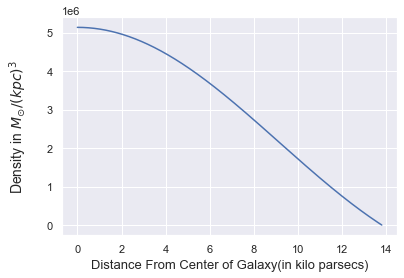

In [110]:
fig, ax = plt.subplots()
plt.plot(r1list/kp,rhorlist/density_conversion);
plt.xlabel('Distance From Center of Galaxy(in kilo parsecs)', fontsize = 13)
plt.ylabel('Density in $M_{\odot}/(kpc)^3$', rotation = 90,fontsize = 14 )


ax.yaxis.set_label_coords(-.10, .5)

In [111]:
B=1.5*10**56.0

def f1(rhor,drhor, r):
    if rhor < 5.87337588753e-11:
        derivs = -4.0*math.pi*rhor**2.0/(B*interpolateddpdrho1(rhor)) - 2.0*drhor/r - drhor**2.0*(interpolatedd2pdrho21(rhor)/interpolateddpdrho1(rhor)- 1.0/rhor)
    #if rhor > 5.87337588753e-11:
    # derivs = -4.0*math.pi*rhor**2.0/(B*interpolateddpdrho2(rhor)) - 2.0*drhor/r - drhor**2.0*(interpolatedd2pdrho22(rhor)/interpolateddpdrho2(rhor)- 1.0/rhor)
    
    else:
        derivs = 0
    return derivs

r1 = 3.431730999999638e+27
rhor = 5.835649358308714e-11
drhor = -1.134989838127895e-34
rstep1 = 2.0*10**21.0

r1list2 =[]
rhorlist2 =[]
drhorlist2 =[]

while(r1< 3.431730999999638e+27 + rstep1*1000000):
    m1 = drhor
    k1 = f1(rhor,drhor,r1)
    m2 = drhor + (rstep1/2.0)*k1
    r1_2 = r1 +(rstep1/2.0)
    rhor_2 = rhor + (rstep1/2.0)*m1
    drhor_2 = m2
    k2 = f1(rhor_2,drhor_2,r1_2)
    m3 = drhor + (rstep1/2.0)*k2
    r1_3 = r1 + (rstep1/2.0)
    rhor_3 = rhor + (rstep1/2.0)*m2
    drhor_3 = m3
    k3 = f1(rhor_3,drhor_3,r1_3)
    m4 = drhor + rstep1*k3
    r1_4 = r1 + rstep1
    rhor_4 = rhor+ rstep1*m3
    drhor_4 = m4
    k4 = f1(rhor_4,drhor_4,r1_4)
    r1 = r1 + rstep1
    rhor = rhor + (rstep1/6.0)*(m1 + 2.0*m2 + 2.0*m3 + m4)
    drhor = drhor + (rstep1/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)
    #r1list.append(r1)
    #rhorlist.append(rhor)
    #drhorlist.append(drhor)
    r1list2.append(r1)
    rhorlist2.append(rhor)
    drhorlist2.append(drhor)

In [112]:
r1list2 = np.array(r1list2)

In [113]:
rhorlist2 = np.array(rhorlist2)

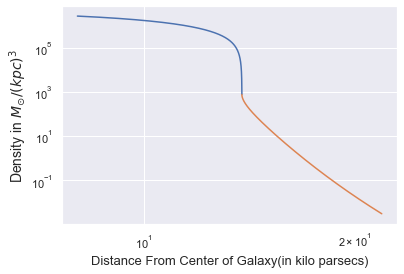

In [114]:
fig, ax = plt.subplots()
plt.loglog(r1list[400000:]/kp,rhorlist[400000:]/density_conversion,r1list2[:]/kp,rhorlist2[:]/density_conversion);
plt.xlabel('Distance From Center of Galaxy(in kilo parsecs)', fontsize = 13)
plt.ylabel('Density in $M_{\odot}/(kpc)^3$', rotation = 90,fontsize = 14 )

ax.yaxis.set_label_coords(-.10, .5)

The fall in density near the phase transition is rapid. That is why the intial choice of density is very important

In [121]:
r1list = list(r1list)
rhorlist = list(rhorlist)

In [122]:
r1list.extend(r1list2)
rhorlist.extend(rhorlist2)

In [123]:
rhodistance = interp1d(r1list,rhorlist)
rhodistance2 = interp1d(r1list2,rhorlist2)

We now plot the integrated mass of this densit profile and compare it with the mass of a theoretical halo having the average dark matter density as dictated by the standard collapse theory.

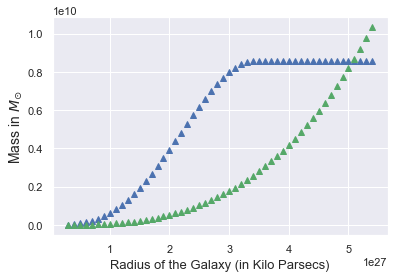

In [134]:
for r1 in my_range(3*10.0**26.0, 5.5*10.0**27.0, 10.0**26.0):

    m1 = integrate.quad(lambda x: 4*math.pi*x**2.0*rhodistance(x)*m,10**23.0,r1)[0]/(1.2*10**66)
    m2 = 4/3*math.pi*1.878134661064889e-08*r1**3.0/(1.2*10**66)
    plt.plot(r1,m1,'b^',r1,m2,'g^')
    plt.xlabel('Radius of the Galaxy (in Kilo Parsecs)', fontsize = 13)
    plt.ylabel('Mass in $M_{\odot}$', rotation = 90,fontsize = 14 )


The intersection point gives us the overall mass and the size of the dark matter halo.

In [141]:
1/(1.5*10**56*2*5*10**27)*(1.5*10**10)*(10**68)

9.999999999999997e-07

We get a value which is very close to the inital temperature we strted out with (1e-6), 